# Introduction to Brian part 3: Simulations

If you haven’t yet read parts 1 and 2 on Neurons and Synapses, go read them first.

This tutorial is about managing the slightly more complicated tasks that crop up in research problems, rather than the toy examples we've been looking at so far. So we cover things like inputting sensory data, modelling experimental conditions, etc.

As before we start by importing the Brian package and setting up matplotlib for IPython:

In [1]:
from brian2 import *
%matplotlib inline

## Multiple runs

Let's start by looking at a very common task: doing multiple runs of a simulation with some parameter that changes. Let's start off with something very simple, how does the firing rate of a leaky integrate-and-fire neuron driven by Poisson spiking neurons change depending on its membrane time constant? Let's set that up.

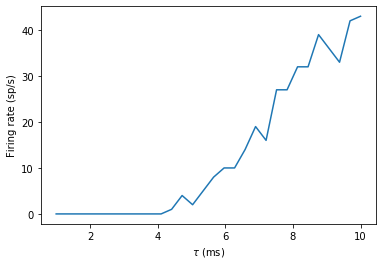

In [2]:
# remember, this is here for running separate simulations in the same notebook
start_scope() 
# Parameters
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
# Range of time constants
tau_range = linspace(1, 10, 30)*ms
# Use this list to store output rates
output_rates = []
# Iterate over range of time constants
for tau in tau_range:
    # Construct the network each time
    P = PoissonGroup(num_inputs, rates=input_rate)
    eqs = '''
    dv/dt = -v/tau : 1
    '''
    G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
    S = Synapses(P, G, on_pre='v += weight')
    S.connect()
    M = SpikeMonitor(G)
    # Run it and store the output firing rate in the list
    run(1*second)
    output_rates.append(M.num_spikes/second)
# And plot it
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

Now if you're running the notebook, you'll see that this was a little slow to run. The reason is that for each loop, you're recreating the objects from scratch. We can improve that by setting up the network just once. We store a copy of the state of the network before the loop, and restore it at the beginning of each iteration.

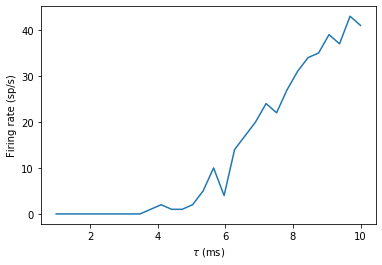

In [3]:
start_scope() 
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the network just once
P = PoissonGroup(num_inputs, rates=input_rate)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
store()
for tau in tau_range:
    # Restore the original state of the network
    restore()
    # Run it with the new value of tau
    run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

That's a very simple example of using store and restore, but you can use it in much more complicated situations. For example, you might want to run a long training run, and then run multiple test runs afterwards. Simply put a store after the long training run, and a restore before each testing run.

You can also see that the output curve is very noisy and doesn't increase monotonically like we'd expect. The noise is coming from the fact that we run the Poisson group afresh each time. If we only wanted to see the effect of the time constant, we could make sure that the spikes were the same each time (although note that really, you ought to do multiple runs and take an average). We do this by running just the Poisson group once, recording its spikes, and then creating a new `SpikeGeneratorGroup` that will output those recorded spikes each time.

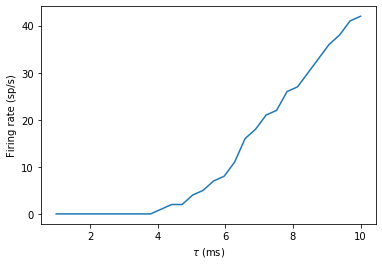

In [4]:
start_scope() 
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the Poisson spikes just once
P = PoissonGroup(num_inputs, rates=input_rate)
MP = SpikeMonitor(P)
# We use a Network object because later on we don't
# want to include these objects
net = Network(P, MP)
net.run(1*second)
# And keep a copy of those spikes
spikes_i = MP.i
spikes_t = MP.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG = SpikeGeneratorGroup(num_inputs, spikes_i, spikes_t)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(SGG, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
net = Network(SGG, G, S, M)
net.store()
for tau in tau_range:
    # Restore the original state of the network
    net.restore()
    # Run it with the new value of tau
    net.run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

You can see that now there is much less noise and it increases monotonically because the input spikes are the same each time, meaning we're seeing the effect of the time constant, not the random spikes.

Note that in the code above, we created `Network` objects. The reason is that in the loop, if we just called `run` it would try to simulate all the objects, including the Poisson neurons ``P``, and we only want to run that once. We use `Network` to specify explicitly which objects we want to include.

The techniques we've looked at so far are the conceptually most simple way to do multiple runs, but not always the most efficient. Since there's only a single output neuron in the model above, we can simply duplicate that output neuron and make the time constant a parameter of the group.

WARNING    "tau" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


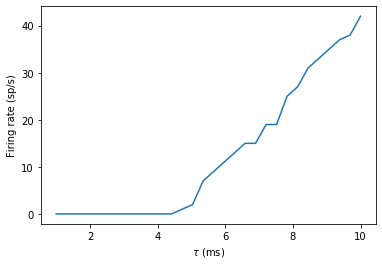

In [5]:
start_scope() 
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
num_tau = len(tau_range)
P = PoissonGroup(num_inputs, rates=input_rate)
# We make tau a parameter of the group
eqs = '''
dv/dt = -v/tau : 1
tau : second
'''
# And we have num_tau output neurons, each with a different tau
G = NeuronGroup(num_tau, eqs, threshold='v>1', reset='v=0', method='exact')
G.tau = tau_range
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Now we can just run once with no loop
run(1*second)
output_rates = M.count/second # firing rate is count/duration
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

You can see that this is much faster again! It's a little bit more complicated conceptually, and it's not always possible to do this trick, but it can be much more efficient if it's possible.

Let's finish with this example by having a quick look at how the mean and standard deviation of the interspike intervals depends on the time constant.

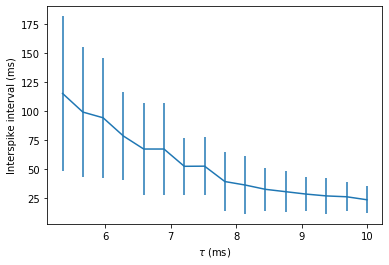

In [6]:
trains = M.spike_trains()
isi_mu = full(num_tau, nan)*second
isi_std = full(num_tau, nan)*second
for idx in range(num_tau):
    train = diff(trains[idx])
    if len(train)>1:
        isi_mu[idx] = mean(train)
        isi_std[idx] = std(train)
errorbar(tau_range/ms, isi_mu/ms, yerr=isi_std/ms)
xlabel(r'$\tau$ (ms)')
ylabel('Interspike interval (ms)');

Notice that we used the ``spike_trains()`` method of `SpikeMonitor`. This is a dictionary with keys being the indices of the neurons and values being the array of spike times for that neuron.

## Changing things during a run

Imagine an experiment where you inject current into a neuron, and change the amplitude randomly every 10 ms. Let's see if we can model that using a Hodgkin-Huxley type neuron.

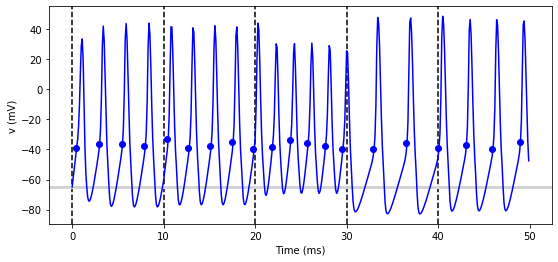

In [7]:
start_scope()
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
# The model
eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
'''
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')
figure(figsize=(9, 4))
for l in range(5):
    group.I = rand()*50*nA
    run(10*ms)
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)');

In the code above, we used a loop over multiple runs to achieve this. That's fine, but it's not the most efficient way to do it because each time we call ``run`` we have to do a lot of initialisation work that slows everything down. It also won't work as well with the more efficient standalone mode of Brian. Here's another way.

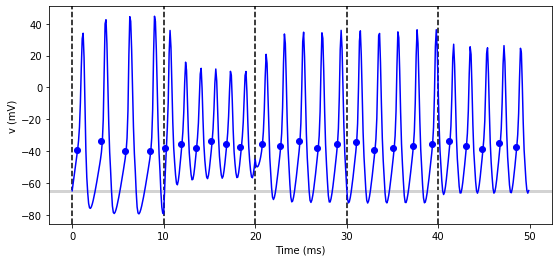

In [8]:
start_scope()
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')
# we replace the loop with a run_regularly
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)
figure(figsize=(9, 4))
# we keep the loop just to draw the vertical lines
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)');

We've replaced the loop that had multiple ``run`` calls with a ``run_regularly``. This makes the specified block of code run every ``dt=10*ms``. The ``run_regularly`` lets you run code specific to a single `NeuronGroup`, but sometimes you might need more flexibility. For this, you can use `network_operation` which lets you run arbitrary Python code (but won't work with the standalone mode).

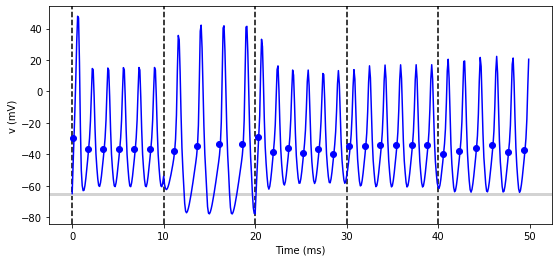

In [9]:
start_scope()
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')
# we replace the loop with a network_operation
@network_operation(dt=10*ms)
def change_I():
    group.I = rand()*50*nA
run(50*ms)
figure(figsize=(9, 4))
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)');

Now let's extend this example to run on multiple neurons, each with a different capacitance to see how that affects the behaviour of the cell.

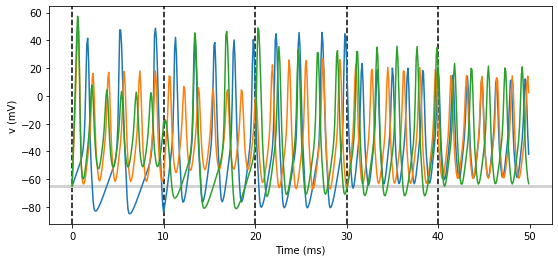

In [10]:
start_scope()
N = 3
eqs_HH_2 = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/C : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
C : farad
'''
group = NeuronGroup(N, eqs_HH_2,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
# initialise with some different capacitances
group.C = array([0.8, 1, 1.2])*ufarad*cm**-2*area
statemon = StateMonitor(group, variables=True, record=True)
# we go back to run_regularly
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)
figure(figsize=(9, 4))
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v.T/mV, '-')
xlabel('Time (ms)')
ylabel('v (mV)');

So that runs, but something looks wrong! The injected currents look like they're different for all the different neurons! Let's check:

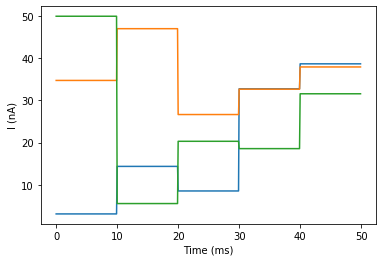

In [11]:
plot(statemon.t/ms, statemon.I.T/nA, '-')
xlabel('Time (ms)')
ylabel('I (nA)');

Sure enough, it's different each time. But why? We wrote ``group.run_regularly('I = rand()*50*nA', dt=10*ms)`` which seems like it should give the same value of I for each neuron. But, like threshold and reset statements, ``run_regularly`` code is interpreted as being run separately for each neuron, and because I is a parameter, it can be different for each neuron. We can fix this by making I into a *shared* variable, meaning it has the same value for each neuron.

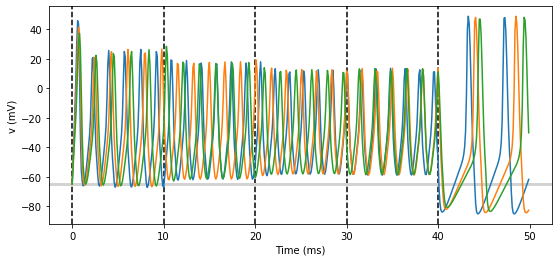

In [12]:
start_scope()
N = 3
eqs_HH_3 = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/C : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp (shared) # everything is the same except we've added this shared
C : farad
'''
group = NeuronGroup(N, eqs_HH_3,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
group.C = array([0.8, 1, 1.2])*ufarad*cm**-2*area
statemon = StateMonitor(group, 'v', record=True)
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)
figure(figsize=(9, 4))
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v.T/mV, '-')
xlabel('Time (ms)')
ylabel('v (mV)');

Ahh, that's more like it!

## Adding input

Now let's think about a neuron being driven by a sinusoidal input. Let's go back to a leaky integrate-and-fire to simplify the equations a bit.

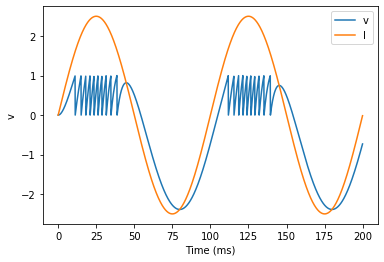

In [13]:
start_scope()
A = 2.5
f = 10*Hz
tau = 5*ms
eqs = '''
dv/dt = (I-v)/tau : 1
I = A*sin(2*pi*f*t) : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='euler')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)
plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best');

So far, so good and the sort of thing we saw in the first tutorial. Now, what if that input current were something we had recorded and saved in a file? In that case, we can use `TimedArray`. Let's start by reproducing the picture above but using `TimedArray`.

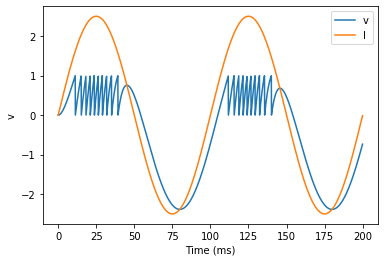

In [14]:
start_scope()
A = 2.5
f = 10*Hz
tau = 5*ms
# Create a TimedArray and set the equations to use it
t_recorded = arange(int(200*ms/defaultclock.dt))*defaultclock.dt
I_recorded = TimedArray(A*sin(2*pi*f*t_recorded), dt=defaultclock.dt)
eqs = '''
dv/dt = (I-v)/tau : 1
I = I_recorded(t) : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)
plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best');

Note that for the example where we put the ``sin`` function directly in the equations, we had to use the ``method='euler'`` argument because the exact integrator wouldn't work here (try it!). However, ``TimedArray`` is considered to be constant over its time step and so the linear integrator can be used. This means you won't get the same behaviour from these two methods for two reasons. Firstly, the numerical integration methods ``exact`` and ``euler`` give slightly different results. Secondly, ``sin`` is not constant over a timestep whereas ``TimedArray`` is.

Now just to show that ``TimedArray`` works for arbitrary currents, let's make a weird "recorded" current and run it on that.

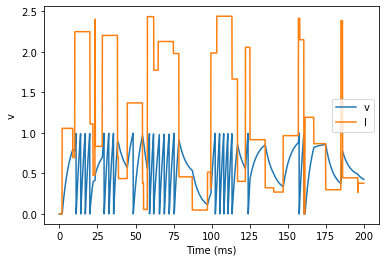

In [15]:
start_scope()
A = 2.5
f = 10*Hz
tau = 5*ms
# Let's create an array that couldn't be
# reproduced with a formula
num_samples = int(200*ms/defaultclock.dt)
I_arr = zeros(num_samples)
for _ in range(100):
    a = randint(num_samples)
    I_arr[a:a+100] = rand()
I_recorded = TimedArray(A*I_arr, dt=defaultclock.dt)
eqs = '''
dv/dt = (I-v)/tau : 1
I = I_recorded(t) : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)
plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best');

Finally, let's finish on an example that actually reads in some data from a file. See if you can work out how this example works.

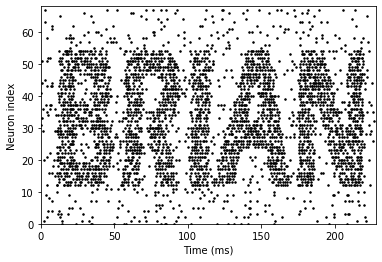

In [16]:
start_scope()
from matplotlib.image import imread
img = (1-imread('brian.png'))[::-1, :, 0].T
num_samples, N = img.shape
ta = TimedArray(img, dt=1*ms) # 228
A = 1.5
tau = 2*ms
eqs = '''
dv/dt = (A*ta(t, i)-v)/tau+0.8*xi*tau**-0.5 : 1
'''
G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='euler')
M = SpikeMonitor(G)
run(num_samples*ms)
plot(M.t/ms, M.i, '.k', ms=3)
xlim(0, num_samples)
ylim(0, N)
xlabel('Time (ms)')
ylabel('Neuron index');